--- 1. Loading Data ---
Successfully loaded nodes.csv and edges3.csv
Nodes_df shape: (479, 8), Edges_df shape: (765, 12)

--- 2. Per-Unit Calculations for Edges ---
Sample edge per-unit calculations:
    voltage         x   i_th_max  V_base_kV_line  Z_base_ohms_line      x_pu  \
0  220000.0  13.88128   112.7854           220.0             484.0  0.028680   
1  380000.0  18.17150  1511.8688           380.0            1444.0  0.012584   
2  220000.0  10.86176   176.5036           220.0             484.0  0.022442   
3  380000.0   8.36775   348.0984           380.0            1444.0  0.005795   
4  380000.0   7.04075   585.7904           380.0            1444.0  0.004876   

   P_th_max_MVA_line  P_th_max_pu_line  
0          42.977009          0.429770  
1         995.080759          9.950808  
2          67.256905          0.672569  
3         229.111164          2.291112  
4         385.555119          3.855551  

--- 3. Constructing NetworkX Graph ---
Initial graph: 479 nodes, 633 edg

NameError: name 'os' is not defined

<Figure size 1080x864 with 0 Axes>

--- 0. Configuration ---

--- 1. Loading Data ---
Successfully loaded nodes.csv and edges3.csv
Nodes_df shape: (479, 10), Edges_df shape: (765, 12)

--- 2. Per-Unit Calculations for Edges ---
Sample edge per-unit calculations:
    voltage         x   i_th_max  V_base_kV_line  Z_base_ohms_line      x_pu  \
0  220000.0  13.88128   112.7854           220.0             484.0  0.028680   
1  380000.0  18.17150  1511.8688           380.0            1444.0  0.012584   
2  220000.0  10.86176   176.5036           220.0             484.0  0.022442   
3  380000.0   8.36775   348.0984           380.0            1444.0  0.005795   
4  380000.0   7.04075   585.7904           380.0            1444.0  0.004876   

   P_th_max_MVA_line  P_th_max_pu_line  
0          42.977009          0.429770  
1         995.080759          9.950808  
2          67.256905          0.672569  
3         229.111164          2.291112  
4         385.555119          3.855551  

--- 3. Constructing NetworkX Graph ---
Initia

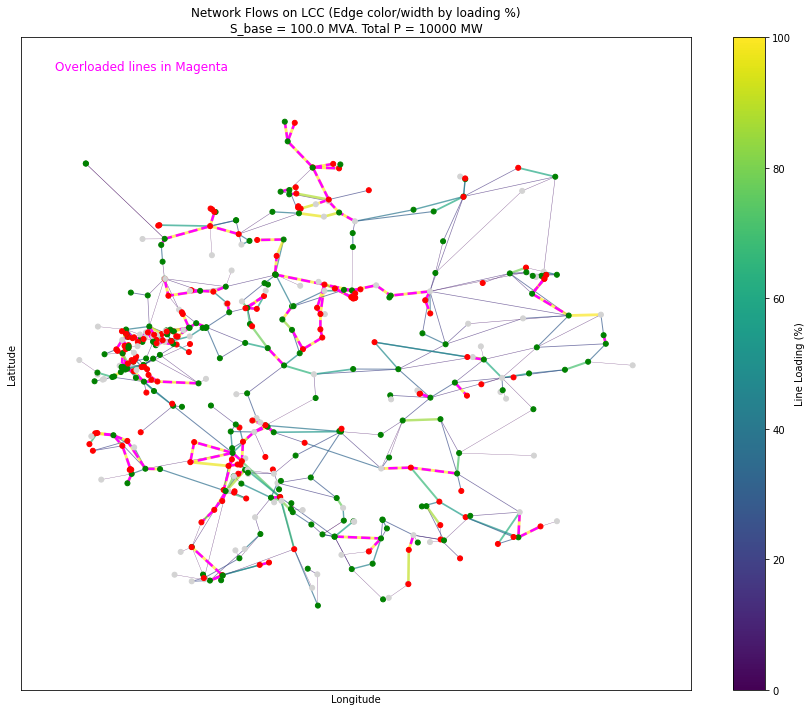


--- 10. Saving Output Files & Preparing Data for GAMS ---
Output files will be saved in: ./output_data_scigrid_milp/
Saved LCC nodes data to: output_data_scigrid_milp/lcc_nodes_complete_data.csv
Saved all edges with PU data to: output_data_scigrid_milp/all_edges_with_pu_values.csv
Saved network flow results to: output_data_scigrid_milp/network_flows_results.csv
Saved thermal violation details to: output_data_scigrid_milp/thermal_violations_details.csv
Saved active NetworkX graph (LCC) to: output_data_scigrid_milp/active_network_lcc.graphml

Preparing and saving GAMS input files...
Saved GAMS nodes input to: output_data_scigrid_milp/gams_input_nodes.csv
Sample GAMS Nodes Data:
    node_id  P_injection_pu
0        1        0.000000
1        2       -2.573922
2        3        0.328888
3        4        0.437291
4        5        0.328888
Saved GAMS edges input to: output_data_scigrid_milp/gams_input_edges.csv

Sample GAMS Edges Data (with new cost_c):
    u    v      x_pu  P_th_max_pu  

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For color mapping
import os # <--- ENSURE THIS IS AT THE TOP

# --- 0. Configuration & Base Values ---
print("--- 0. Configuration ---")
S_base_MVA = 100.0  # System Base Power in MVA
SHOW_FULL_NETWORK_PLOT = False # Set to True to display the initial large network plot
SHOW_FLOW_PLOT = True        # Set to True to display the network plot with flow loading

# Configuration for Reinforcement Cost Generation
COST_GENERATION_METHOD = "LENGTH_PROPORTIONAL" # Options: "LENGTH_PROPORTIONAL", "UNIFORM"
BASE_COST_PER_KM = 1000.0 # Arbitrary cost units per kilometer (e.g., 1000 EUR/km)
UNIFORM_COST_VALUE = 1.0 # Cost if using UNIFORM method or if length is unavailable for a line

# --- 1. Load Data ---
print("\n--- 1. Loading Data ---")
try:
    edges_df = pd.read_csv('edges3.csv')
    nodes_df = pd.read_csv('nodes.csv')
    print("Successfully loaded nodes.csv and edges3.csv")
    print(f"Nodes_df shape: {nodes_df.shape}, Edges_df shape: {edges_df.shape}")
except FileNotFoundError:
    print("ERROR: Ensure 'nodes.csv' and 'edges3.csv' are in the same directory as the script.")
    exit()

# Clean node IDs
nodes_df['v_id'] = nodes_df['v_id'].astype(int)
edges_df['v_id_1'] = edges_df['v_id_1'].astype(int)
edges_df['v_id_2'] = edges_df['v_id_2'].astype(int)

# Ensure lon and lat are numeric, handle potential errors/NaNs
for col in ['lon', 'lat']:
    if col in nodes_df.columns:
        nodes_df[col] = pd.to_numeric(nodes_df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in nodes_df. Geographic plotting might fail.")
        nodes_df[col] = np.nan # Create column with NaN if missing, to prevent later errors

# --- 2. Per-Unit Calculations for Edges ---
print("\n--- 2. Per-Unit Calculations for Edges ---")
edges_df['V_base_kV_line'] = edges_df['voltage'] / 1000.0
edges_df['Z_base_ohms_line'] = (edges_df['V_base_kV_line']**2) / S_base_MVA
edges_df['x_pu'] = np.where(edges_df['Z_base_ohms_line'] == 0, np.nan, edges_df['x'] / edges_df['Z_base_ohms_line'])
if edges_df['x_pu'].isnull().any():
    print("Warning: Some x_pu values are NaN due to Z_base_ohms_line being zero. Check 'voltage' in edges_df.")

# Thermal Limit Conversion (P_th_max_pu)
# Assuming 'i_th_max' is in Amperes (A)
edges_df['I_th_max_kA'] = edges_df['i_th_max'] / 1000.0
edges_df['P_th_max_MVA_line'] = np.sqrt(3) * edges_df['V_base_kV_line'] * edges_df['I_th_max_kA']
edges_df['P_th_max_pu_line'] = edges_df['P_th_max_MVA_line'] / S_base_MVA

print("Sample edge per-unit calculations:")
print(edges_df[['voltage', 'x', 'i_th_max', 'V_base_kV_line', 'Z_base_ohms_line', 'x_pu', 'P_th_max_MVA_line', 'P_th_max_pu_line']].head())

# --- 3. Construct NetworkX Graph with Per-Unit Attributes ---
print("\n--- 3. Constructing NetworkX Graph ---")
G_initial = nx.Graph()

# Add nodes with attributes
for _, row in nodes_df.iterrows():
    node_id = int(row['v_id'])
    node_attrs = {
        'typ': row.get('typ'),
        'voltage_V_node': row.get('voltage'),
        'degree_centrality': row.get('degree_centrality'),
        'pagerank': row.get('pagerank'),
        'betweenness': row.get('betweenness')
    }
    # Add lon/lat only if they are valid numbers
    if pd.notna(row.get('lon')) and pd.notna(row.get('lat')):
        node_attrs['lon'] = row['lon']
        node_attrs['lat'] = row['lat']
    G_initial.add_node(node_id, **node_attrs)

# Add edges with attributes
for _, row in edges_df.iterrows():
    if pd.isna(row['x_pu']) or row['x_pu'] == 0:
        continue

    current_reinforcement_cost = UNIFORM_COST_VALUE
    if COST_GENERATION_METHOD == "LENGTH_PROPORTIONAL":
        if 'length_m' in row and pd.notna(row['length_m']) and row['length_m'] > 0:
            length_km = row['length_m'] / 1000.0
            current_reinforcement_cost = length_km * BASE_COST_PER_KM
        else:
            # print(f"Warning: Length not available/invalid for edge ({row['v_id_1']}-{row['v_id_2']}). Using uniform cost.")
            current_reinforcement_cost = UNIFORM_COST_VALUE
    elif COST_GENERATION_METHOD == "UNIFORM":
        current_reinforcement_cost = UNIFORM_COST_VALUE

    G_initial.add_edge(int(row['v_id_1']), int(row['v_id_2']),
                       voltage_V_line=row['voltage'],
                       x_ohm=row['x'],
                       i_th_max_orig_unit=row['i_th_max'],
                       capacitance_orig_scigrid_val=row['c'],
                       x_pu=row['x_pu'],
                       P_th_max_pu=row['P_th_max_pu_line'],
                       cost_for_reinforcement=current_reinforcement_cost,
                       r_ohm=row.get('r'),
                       length_m=row.get('length_m', np.nan)
                       )
print(f"Initial graph: {G_initial.number_of_nodes()} nodes, {G_initial.number_of_edges()} edges.")

if SHOW_FULL_NETWORK_PLOT and G_initial.number_of_nodes() > 0:
    print("Plotting initial full network (may take time)...")
    pos_initial = {node: (data['lon'], data['lat']) for node, data in G_initial.nodes(data=True)
                   if 'lon' in data and 'lat' in data and pd.notna(data['lon']) and pd.notna(data['lat'])}
    if pos_initial:
        plt.figure(figsize=(12, 10))
        nx.draw(G_initial, pos_initial, node_size=10, width=0.5, edge_color='gray', with_labels=False)
        plt.title('Initial Full SciGRID Network (Geographic Layout)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print("No valid positional data for initial graph plot.")

# --- 4. Extract Largest Connected Component (LCC) ---
# (Code from here down to before section 10 is largely the same as your successful run)
print("\n--- 4. Extracting Largest Connected Component (LCC) ---")
if G_initial.number_of_nodes() > 0:
    largest_cc_nodes = max(nx.connected_components(G_initial), key=len, default=[])
    if not largest_cc_nodes:
        print("ERROR: No connected components found in G_initial.")
        exit()
    G_active = G_initial.subgraph(largest_cc_nodes).copy()
    print(f"LCC (G_active): {G_active.number_of_nodes()} nodes, {G_active.number_of_edges()} edges.")
    nodes_in_lcc_df = nodes_df[nodes_df['v_id'].isin(G_active.nodes())].copy()
    if nodes_in_lcc_df.empty and G_active.number_of_nodes() > 0 :
        print("Warning: No nodes from nodes_df are in the LCC based on v_id matching, but LCC exists.")
        # This state might indicate an issue if subsequent operations rely heavily on nodes_in_lcc_df
        # For now, we'll proceed as G_active itself might have enough data from G_initial
else:
    print("Initial graph is empty. Cannot proceed.")
    exit()

# --- 5. Synthetic Load & Generation Allocation (on LCC nodes) ---
print("\n--- 5. Synthetic Load & Generation Allocation (on LCC nodes) ---")
if not nodes_in_lcc_df.empty:
    nodes_in_lcc_df['voltage_V_node'] = pd.to_numeric(nodes_in_lcc_df.get('voltage', pd.Series(dtype='float')), errors='coerce')

    def min_max_normalize(series):
        if series.empty or series.max() == series.min():
            return pd.Series(0.5, index=series.index) if not series.empty else pd.Series(dtype='float')
        return (series - series.min()) / (series.max() - series.min())

    norm_degree = min_max_normalize(nodes_in_lcc_df.get('degree_centrality', pd.Series(dtype='float')))
    norm_betweenness = min_max_normalize(nodes_in_lcc_df.get('betweenness', pd.Series(dtype='float')))
    norm_pagerank = min_max_normalize(nodes_in_lcc_df.get('pagerank', pd.Series(dtype='float')))

    combined_score_load = pd.Series(0.0, index=nodes_in_lcc_df.index)
    if not norm_degree.empty and not norm_betweenness.empty and not norm_pagerank.empty:
        centrality_matrix_load = np.vstack([norm_degree, norm_betweenness, norm_pagerank]).T
        if centrality_matrix_load.shape[0] > 0:
            pij_load = centrality_matrix_load / (centrality_matrix_load.sum(axis=0) + 1e-9)
            pij_load = np.where(pij_load == 0, 1e-10, pij_load)
            entropy_load = -np.sum(pij_load * np.log(pij_load), axis=0) / (np.log(len(nodes_in_lcc_df)) + 1e-9)
            diversity_load = 1 - entropy_load
            entropy_weights_load = diversity_load / (diversity_load.sum() + 1e-9)
            combined_score_load = pd.Series((centrality_matrix_load * entropy_weights_load).sum(axis=1), index=nodes_in_lcc_df.index)
    nodes_in_lcc_df['combined_centrality_score_load'] = combined_score_load
    nodes_in_lcc_df['combined_centrality_score_gen'] = norm_pagerank if not norm_pagerank.empty else pd.Series(0.0, index=nodes_in_lcc_df.index)

    load_eligible_nodes = nodes_in_lcc_df[nodes_in_lcc_df['voltage_V_node'] <= 220000] if 'voltage_V_node' in nodes_in_lcc_df else pd.DataFrame()
    load_score_sum = load_eligible_nodes['combined_centrality_score_load'].sum() if not load_eligible_nodes.empty else 0

    gen_eligible_nodes = nodes_in_lcc_df[nodes_in_lcc_df['voltage_V_node'] >= 380000] if 'voltage_V_node' in nodes_in_lcc_df else pd.DataFrame()
    gen_score_sum = gen_eligible_nodes['combined_centrality_score_gen'].sum() if not gen_eligible_nodes.empty else 0

    total_load_MW = 10000
    total_generation_MW = 10000

    nodes_in_lcc_df['load_MW'] = 0.0
    if load_score_sum > 0 and not load_eligible_nodes.empty:
        nodes_in_lcc_df.loc[load_eligible_nodes.index, 'load_MW'] = \
            (load_eligible_nodes['combined_centrality_score_load'] / load_score_sum) * total_load_MW

    nodes_in_lcc_df['generation_MW'] = 0.0
    if gen_score_sum > 0 and not gen_eligible_nodes.empty:
        nodes_in_lcc_df.loc[gen_eligible_nodes.index, 'generation_MW'] = \
            (gen_eligible_nodes['combined_centrality_score_gen'] / gen_score_sum) * total_generation_MW

    nodes_in_lcc_df['load_pu'] = nodes_in_lcc_df['load_MW'] / S_base_MVA
    nodes_in_lcc_df['generation_pu'] = nodes_in_lcc_df['generation_MW'] / S_base_MVA
    nodes_in_lcc_df['P_injection_pu'] = nodes_in_lcc_df['generation_pu'] - nodes_in_lcc_df['load_pu']

    for index, row in nodes_in_lcc_df.iterrows():
        node_id = int(row['v_id'])
        if G_active.has_node(node_id):
            for col in ['load_MW', 'generation_MW', 'load_pu', 'generation_pu', 'P_injection_pu']:
                G_active.nodes[node_id][col] = row[col]
else:
    print("LCC nodes dataframe is empty. Manually assigning P_injection_pu=0 to G_active nodes for DC flow.")
    for node_id in G_active.nodes(): G_active.nodes[node_id]['P_injection_pu'] = 0.0
    nodes_in_lcc_df = pd.DataFrame(columns=['v_id', 'voltage_V_node', 'load_MW', 'generation_MW', 'P_injection_pu']) # Ensure it exists

print("Sample nodal power allocations (LCC nodes):")
print(nodes_in_lcc_df[['v_id', 'voltage_V_node', 'load_MW', 'generation_MW', 'P_injection_pu']].head())
print(f"Total Load MW allocated: {nodes_in_lcc_df['load_MW'].sum():.2f}")
print(f"Total Generation MW allocated: {nodes_in_lcc_df['generation_MW'].sum():.2f}")
print(f"Net P_injection_pu sum: {nodes_in_lcc_df['P_injection_pu'].sum():.4f}")


# --- 6. DC Power Flow in Per-Unit System (on G_active) ---
print("\n--- 6. DC Power Flow (Per-Unit) ---")
flows_pu_df = pd.DataFrame() # Initialize
if G_active.number_of_nodes() == 0 or G_active.number_of_edges() == 0:
    print("G_active is empty or has no edges. Skipping DC Power Flow.")
else:
    active_node_ids_list = list(G_active.nodes())
    n_active_nodes = len(active_node_ids_list)
    active_node_to_idx_map = {node_id: idx for idx, node_id in enumerate(active_node_ids_list)}
    P_injection_vector_pu = np.array([G_active.nodes[node_id].get('P_injection_pu', 0.0) for node_id in active_node_ids_list])
    B_matrix_pu = np.zeros((n_active_nodes, n_active_nodes))
    valid_edges_for_b_matrix = 0
    for u, v, data in G_active.edges(data=True):
        if 'x_pu' not in data or pd.isna(data['x_pu']) or data['x_pu'] == 0: continue
        valid_edges_for_b_matrix +=1
        idx_u, idx_v = active_node_to_idx_map[u], active_node_to_idx_map[v]
        susceptance = 1.0 / data['x_pu']
        B_matrix_pu[idx_u, idx_v] -= susceptance; B_matrix_pu[idx_v, idx_u] -= susceptance
        B_matrix_pu[idx_u, idx_u] += susceptance; B_matrix_pu[idx_v, idx_v] += susceptance
    
    if valid_edges_for_b_matrix == 0:
        print("No valid edges with x_pu found to build B-matrix. Skipping DC flow.")
        theta_pu = np.full(n_active_nodes, np.nan)
    else:
        slack_node_id_chosen = active_node_ids_list[0]
        slack_idx_in_matrix = active_node_to_idx_map[slack_node_id_chosen]
        print(f"Chosen Slack Bus ID: {slack_node_id_chosen} (Index: {slack_idx_in_matrix})")
        B_reduced_pu = np.delete(np.delete(B_matrix_pu, slack_idx_in_matrix, axis=0), slack_idx_in_matrix, axis=1)
        P_reduced_pu = np.delete(P_injection_vector_pu, slack_idx_in_matrix)
        try:
            if np.linalg.cond(B_reduced_pu) < 1/np.finfo(B_reduced_pu.dtype).eps:
                 theta_reduced_pu = np.linalg.solve(B_reduced_pu, P_reduced_pu)
            else:
                print("Warning: Singular or ill-conditioned B_reduced_pu matrix. Using pseudo-inverse (lstsq).")
                theta_reduced_pu = np.linalg.lstsq(B_reduced_pu, P_reduced_pu, rcond=None)[0]
            theta_pu = np.insert(theta_reduced_pu, slack_idx_in_matrix, 0.0)
        except np.linalg.LinAlgError:
            print("ERROR: LinAlgError during DC flow solve. Check for islands or B' construction.")
            theta_pu = np.full(n_active_nodes, np.nan)
        flows_pu_list = []
        if not np.isnan(theta_pu).all():
            for u, v, data in G_active.edges(data=True):
                idx_u, idx_v = active_node_to_idx_map[u], active_node_to_idx_map[v]
                flow_val_pu = np.nan
                if 'x_pu' in data and not pd.isna(data['x_pu']) and data['x_pu'] != 0:
                    if not (np.isnan(theta_pu[idx_u]) or np.isnan(theta_pu[idx_v])):
                         flow_val_pu = (theta_pu[idx_u] - theta_pu[idx_v]) / data['x_pu']
                thermal_limit_val_pu = data.get('P_th_max_pu', np.inf)
                loading_pct = (np.abs(flow_val_pu) / thermal_limit_val_pu) * 100 if thermal_limit_val_pu > 0 and not pd.isna(flow_val_pu) else 0.0
                flows_pu_list.append({'from': u, 'to': v, 'flow_pu': flow_val_pu, 'x_pu': data.get('x_pu'),
                                      'theta_from': theta_pu[idx_u], 'theta_to': theta_pu[idx_v],
                                      'thermal_limit_pu': thermal_limit_val_pu, 'loading_pct': loading_pct})
        flows_pu_df = pd.DataFrame(flows_pu_list)
        print(f"Slack Bus Angle (Node {slack_node_id_chosen}): {theta_pu[slack_idx_in_matrix]:.6f} rad")
        print("Sample Voltage Angles (radians, first 5 active nodes):")
        for i in range(min(5, n_active_nodes)): print(f"Node {active_node_ids_list[i]}: {theta_pu[active_node_to_idx_map[active_node_ids_list[i]]]:.6f} rad")
        print("\nSample Line Flows (p.u.):")
        print(flows_pu_df[['from', 'to', 'flow_pu', 'thermal_limit_pu', 'loading_pct']].head())
        for i, node_id in enumerate(active_node_ids_list):
            if not np.isnan(theta_pu[i]):
                G_active.nodes[node_id]['theta_pu'] = theta_pu[i]
                if not nodes_in_lcc_df.empty and 'v_id' in nodes_in_lcc_df.columns:
                     nodes_in_lcc_df.loc[nodes_in_lcc_df['v_id'] == node_id, 'theta_pu'] = theta_pu[i]

# --- 7. Thermal Limit Violation Detection & Reporting ---
print("\n--- 7. Thermal Limit Violations ---")
violations_df = pd.DataFrame() # Initialize
if not flows_pu_df.empty:
    valid_flows_for_violations_df = flows_pu_df.dropna(subset=['flow_pu', 'thermal_limit_pu'])
    violations_df = valid_flows_for_violations_df[
        np.abs(valid_flows_for_violations_df['flow_pu']) > valid_flows_for_violations_df['thermal_limit_pu']
    ]
print(f"Number of thermal limit violations (p.u. based): {len(violations_df)}")
if len(violations_df) > 0:
    print("Violating lines (p.u.):")
    print(violations_df[['from', 'to', 'flow_pu', 'thermal_limit_pu', 'loading_pct']].head())

# --- 8. Sanity Checks for Per-Unit Values ---
# (Largely unchanged, assumed to be working from your output)
print("\n--- 8. Sanity Checks for Per-Unit Values ---")
print(f"S_base_MVA used: {S_base_MVA}")
if G_active.number_of_nodes() > 0:
    active_p_injections = [G_active.nodes[node_id].get('P_injection_pu', 0) for node_id in G_active.nodes()]
    print(f"Total P_injection_pu sum in G_active: {sum(active_p_injections):.4f}")
    print("Sample P_injection_pu values from G_active (first 5):")
    for i, node_id in enumerate(G_active.nodes()):
        if i >= 5: break
        print(f"Node {node_id}: P_injection_pu = {G_active.nodes[node_id].get('P_injection_pu', 'N/A'):.4f}")
    print("\nSample x_pu values from G_active edges (first 5):")
    for i, (u,v,data) in enumerate(G_active.edges(data=True)):
        if i >= 5: break
        print(f"Edge ({u}-{v}): x_pu = {data.get('x_pu', 'N/A'):.4f}")
    print("\nSample edge P_th_max_pu and calculated loading (first 5 from flows_df):")
    print(flows_pu_df[['from', 'to', 'flow_pu', 'thermal_limit_pu', 'loading_pct']].head())
else:
    print("G_active is empty, skipping sanity checks for G_active components.")

# --- 9. Visualization of Network Flows & Overloads (on G_active) ---
if SHOW_FLOW_PLOT and G_active.number_of_nodes() > 0 and G_active.number_of_edges() > 0 and not flows_pu_df.empty:
    print("\n--- 9. Plotting Network Flows (on LCC) ---")
    plt.figure(figsize=(15, 12))
    # Robustly create pos_active, only including nodes with valid lon/lat
    pos_active = {node: (data['lon'], data['lat'])
                  for node, data in G_active.nodes(data=True)
                  if 'lon' in data and 'lat' in data and pd.notna(data['lon']) and pd.notna(data['lat'])}

    if not pos_active:
        print("No valid positional data (lon, lat) for nodes in G_active. Cannot create geographic plot.")
    else:
        # Get a list of nodes that are actually in pos_active for drawing
        drawable_nodes = list(pos_active.keys())
        
        node_colors = []
        for node in drawable_nodes: # Iterate only over nodes we can draw
            p_inj = G_active.nodes[node].get('P_injection_pu', 0)
            if p_inj > 1e-3 : node_colors.append('green')
            elif p_inj < -1e-3: node_colors.append('red')
            else: node_colors.append('lightgray')

        nx.draw_networkx_nodes(G_active, pos_active, nodelist=drawable_nodes, node_size=25, node_color=node_colors)

        edge_colors, edge_widths = [], []
        max_loading_for_viz = 100.0
        flow_map = {tuple(sorted((r['from'],r['to']))): r['loading_pct'] for _, r in flows_pu_df.iterrows() if pd.notna(r['loading_pct'])}

        drawable_edges = [(u,v) for u,v in G_active.edges() if u in pos_active and v in pos_active] # Edges between drawable nodes

        for u, v in drawable_edges:
            loading = flow_map.get(tuple(sorted((u,v))), 0)
            norm_loading = min(loading, max_loading_for_viz) / max_loading_for_viz if max_loading_for_viz > 0 else 0
            edge_colors.append(cm.viridis(norm_loading))
            edge_widths.append(0.3 + norm_loading * 2.5)

        nx.draw_networkx_edges(G_active, pos_active, edgelist=drawable_edges, edge_color=edge_colors, width=edge_widths, alpha=0.7)

        if not violations_df.empty:
            overloaded_drawable_edges = [(r['from'],r['to']) for _, r in violations_df.iterrows()
                                         if r['from'] in pos_active and r['to'] in pos_active]
            if overloaded_drawable_edges:
                nx.draw_networkx_edges(G_active, pos_active, edgelist=overloaded_drawable_edges,
                                       edge_color='magenta', width=2.5, style='dashed')
                plt.text(0.05, 0.95, 'Overloaded lines in Magenta', transform=plt.gca().transAxes,
                         color='magenta', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        plt.title(f'Network Flows on LCC (Edge color/width by loading %)\nS_base = {S_base_MVA} MVA. Total P = {total_load_MW} MW')
        plt.xlabel('Longitude'); plt.ylabel('Latitude')
        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=0, vmax=max_loading_for_viz))
        sm.set_array([]); cbar = plt.colorbar(sm); cbar.set_label('Line Loading (%)')
        plt.axis('equal') # Often good for geographic plots
        plt.show()
else:
    if SHOW_FLOW_PLOT: print("Skipping flow plot due to missing data or G_active being empty.")


# --- 10. Save Output Files & Prepare Data for GAMS ---
print("\n--- 10. Saving Output Files & Preparing Data for GAMS ---")
output_dir = "output_data_scigrid_milp"
os.makedirs(output_dir, exist_ok=True)
print(f"Output files will be saved in: ./{output_dir}/")

if not nodes_in_lcc_df.empty:
    nodes_in_lcc_df.to_csv(os.path.join(output_dir, "lcc_nodes_complete_data.csv"), index=False)
    print(f"Saved LCC nodes data to: {os.path.join(output_dir, 'lcc_nodes_complete_data.csv')}")
if not edges_df.empty:
    edges_df.to_csv(os.path.join(output_dir, "all_edges_with_pu_values.csv"), index=False)
    print(f"Saved all edges with PU data to: {os.path.join(output_dir, 'all_edges_with_pu_values.csv')}")
if not flows_pu_df.empty:
    flows_pu_df.to_csv(os.path.join(output_dir, "network_flows_results.csv"), index=False)
    print(f"Saved network flow results to: {os.path.join(output_dir, 'network_flows_results.csv')}")
if not violations_df.empty:
    violations_df.to_csv(os.path.join(output_dir, "thermal_violations_details.csv"), index=False)
    print(f"Saved thermal violation details to: {os.path.join(output_dir, 'thermal_violations_details.csv')}")
elif 'violations_df' in locals() and violations_df.empty : print("No thermal violations to save (violations_df is empty).")
if G_active.number_of_nodes() > 0:
    nx.write_graphml(G_active, os.path.join(output_dir, "active_network_lcc.graphml"))
    print(f"Saved active NetworkX graph (LCC) to: {os.path.join(output_dir, 'active_network_lcc.graphml')}")

print("\nPreparing and saving GAMS input files...")
if G_active.number_of_nodes() > 0:
    gams_nodes_df = pd.DataFrame(
        [{'node_id': n, 'P_injection_pu': G_active.nodes[n].get('P_injection_pu', 0.0)} for n in G_active.nodes()]
    )
    gams_nodes_df.to_csv(os.path.join(output_dir, "gams_input_nodes.csv"), index=False)
    print(f"Saved GAMS nodes input to: {os.path.join(output_dir, 'gams_input_nodes.csv')}")
    print("Sample GAMS Nodes Data:\n", gams_nodes_df.head())

    if G_active.number_of_edges() > 0:
        gams_edges_list = []
        for u, v, data in G_active.edges(data=True):
            gams_edges_list.append({
                'u': u, 'v': v,
                'x_pu': data.get('x_pu', np.nan),
                'P_th_max_pu': data.get('P_th_max_pu', np.inf),
                'cost_c': data.get('cost_for_reinforcement', UNIFORM_COST_VALUE)
            })
        gams_edges_df = pd.DataFrame(gams_edges_list)
        gams_edges_df.to_csv(os.path.join(output_dir, "gams_input_edges.csv"), index=False)
        print(f"Saved GAMS edges input to: {os.path.join(output_dir, 'gams_input_edges.csv')}")
        print("\nSample GAMS Edges Data (with new cost_c):\n", gams_edges_df.head())
    else: print("G_active has no edges. Skipping GAMS edges data saving.")
else: print("G_active is empty. Skipping GAMS nodes and edges data saving.")

print(f"\nReinforcement cost ('cost_c') in 'gams_input_edges.csv' generated using method: {COST_GENERATION_METHOD}.")
if COST_GENERATION_METHOD == "LENGTH_PROPORTIONAL": print(f"Base cost per km used: {BASE_COST_PER_KM}")
print("The 'c' column from 'edges3.csv' is treated as capacitance ('capacitance_orig_scigrid_val' on graph edges).")
print("\nAll requested files have been processed for saving.")
print("--- Script Finished ---")

In [6]:
pip install pyomo

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.4 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 7.8 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.5 MB 4.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For color mapping
import os # <--- ENSURE THIS IS AT THE TOP
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

import pandas as pd
import pyomo.environ as pyo # Make sure this is how you import pyomo
from pyomo.opt import SolverFactory
import os
import numpy as np # Ensure numpy is imported

# --- 0. Configuration for Pyomo Model ---
print("--- Pyomo Model Configuration ---")
REINFORCEMENT_CAPACITY_MULTIPLIER = 2.0
TOTAL_BUDGET = 50000.0 # Adjusted for a smaller dataset, can fine-tune
SLACK_NODE_ID = None # Will be set from the subset
MAX_NODES_FOR_SUBSET = 30 # <<---- SET THE DESIRED NUMBER OF NODES FOR THE SUBSET

# --- 1. Load Data for Pyomo ---
print("\n--- Loading Data for Pyomo ---")
output_dir = "output_data_scigrid_milp"
try:
    nodes_py_df_full = pd.read_csv(os.path.join(output_dir, "gams_input_nodes.csv"))
    edges_py_df_full = pd.read_csv(os.path.join(output_dir, "gams_input_edges.csv"))
    print("Successfully loaded GAMS input CSVs for Pyomo.")
except FileNotFoundError:
    print(f"ERROR: CSV files not found in {output_dir}. Make sure previous script ran successfully.")
    exit()

# --- Create a Subset of the Data ---
print(f"\n--- Creating a data subset with approx. {MAX_NODES_FOR_SUBSET} nodes ---")

# Take the first MAX_NODES_FOR_SUBSET nodes
# It's better if these nodes are connected. We can use the LCC logic from the main script
# or simply take a slice and then find the LCC of that slice.
# For simplicity here, let's take a slice of nodes and then filter edges.
# If your nodes_py_df_full is already sorted in a way that early nodes are connected (e.g., from LCC), this is easier.

if len(nodes_py_df_full) < MAX_NODES_FOR_SUBSET:
    print(f"Warning: Requested subset size {MAX_NODES_FOR_SUBSET} is larger than available nodes ({len(nodes_py_df_full)}). Using all available nodes.")
    nodes_subset_ids = nodes_py_df_full['node_id'].tolist()
else:
    # A more robust way to get a connected subset:
    # 1. Build a temporary graph from the full edges_py_df_full
    # 2. Take a seed node (e.g., the first one)
    # 3. Do a breadth-first search (BFS) or depth-first search (DFS) to get MAX_NODES_FOR_SUBSET connected nodes
    
    # Simpler approach for now: just take the first N nodes.
    # This might result in a disconnected graph if the original node order doesn't preserve locality.
    # nodes_subset_ids = nodes_py_df_full['node_id'].head(MAX_NODES_FOR_SUBSET).tolist()
    
    # More robust subset selection using NetworkX to ensure connectivity:
    print("Selecting a connected subset of nodes using NetworkX...")
    G_temp_full = nx.Graph()
    for _, row in edges_py_df_full.iterrows():
        G_temp_full.add_edge(int(row['u']), int(row['v']))
    
    if not G_temp_full.nodes:
        print("ERROR: Full graph has no nodes. Cannot create subset.")
        exit()

    # Try to get the LCC of the full graph first, then take a subset from it
    if G_temp_full.number_of_nodes() > 0:
        full_lcc_nodes = list(max(nx.connected_components(G_temp_full), key=len, default=[]))
        if not full_lcc_nodes:
             print("Warning: Full graph is disconnected or empty, trying to pick from available nodes.")
             full_lcc_nodes = list(G_temp_full.nodes()) # Fallback

        if not full_lcc_nodes:
            print("ERROR: No nodes to select for subset even after fallback.")
            exit()
            
        seed_node = full_lcc_nodes[0] # Start with the first node of the LCC
        
        # Use BFS to get a connected subgraph of desired size
        nodes_subset_ids = list(nx.bfs_tree(G_temp_full, source=seed_node, depth_limit=None))[:MAX_NODES_FOR_SUBSET]

        if len(nodes_subset_ids) < 2 and len(full_lcc_nodes) >=2 : # If BFS yields too few (e.g. isolated seed), try another seed or small component
             print(f"BFS from {seed_node} yielded only {len(nodes_subset_ids)} node(s). Trying to take first {MAX_NODES_FOR_SUBSET} from LCC.")
             nodes_subset_ids = full_lcc_nodes[:MAX_NODES_FOR_SUBSET]


    if not nodes_subset_ids:
        print("ERROR: Could not select any nodes for the subset.")
        exit()

nodes_py_df = nodes_py_df_full[nodes_py_df_full['node_id'].isin(nodes_subset_ids)].copy()
print(f"Selected {len(nodes_py_df)} nodes for the subset.")

# Filter edges to only include those connecting nodes within the subset
edges_py_df = edges_py_df_full[
    edges_py_df_full['u'].isin(nodes_subset_ids) & edges_py_df_full['v'].isin(nodes_subset_ids)
].copy()
print(f"Selected {len(edges_py_df)} edges connecting these subset nodes.")

if nodes_py_df.empty or edges_py_df.empty:
    print("ERROR: Subset resulted in no nodes or no edges. Try increasing MAX_NODES_FOR_SUBSET or check data.")
    exit()

# Re-assign SLACK_NODE_ID to be the first node in our new subset
if not nodes_py_df.empty:
    SLACK_NODE_ID = int(nodes_py_df['node_id'].iloc[0])
    print(f"New Slack Node ID for subset: {SLACK_NODE_ID}")
else:
    print("ERROR: Node subset is empty, cannot assign slack node.")
    exit()


# --- Data Preprocessing for Pyomo (using the subset) ---
node_ids_list = nodes_py_df['node_id'].tolist()
power_injections = dict(zip(nodes_py_df['node_id'], nodes_py_df['P_injection_pu']))

lines_list_tuples = []
reactances = {}
initial_thermal_limits = {}
reinforcement_costs = {}

# Ensure u < v for undirected representation
edges_py_df['min_node'] = edges_py_df[['u', 'v']].min(axis=1)
edges_py_df['max_node'] = edges_py_df[['u', 'v']].max(axis=1)
# Drop duplicates again on the subset, though the initial full df was already processed
edges_py_df = edges_py_df.drop_duplicates(subset=['min_node', 'max_node'])
# Use original u,v for dict keys if they were specific, but for undirected, min_node, max_node is safer
edges_py_df_for_params = edges_py_df.drop(columns=['u', 'v']).rename(columns={'min_node': 'u', 'max_node': 'v'})


for _, row in edges_py_df_for_params.iterrows():
    u, v = int(row['u']), int(row['v'])
    line = (u,v) # u is already < v due to min_node, max_node logic
    lines_list_tuples.append(line)
    reactances[line] = row['x_pu']
    initial_thermal_limits[line] = row['P_th_max_pu']
    reinforcement_costs[line] = row['cost_c']


total_possible_cost_subset = sum(reinforcement_costs.values())
print(f"Total cost to reinforce ALL lines in SUBSET: {total_possible_cost_subset:.2f}")
# Adjust budget based on the subset if desired, or keep the globally set one
# For a small subset, the initial 50000 might be too high or too low.
# Let's make it proportional to the total cost of subset lines
if total_possible_cost_subset > 0:
    TOTAL_BUDGET = total_possible_cost_subset * 0.2 # e.g., 20% of subset total cost
else:
    TOTAL_BUDGET = 1000 # A small default if no costs/lines
print(f"Using reinforcement budget for SUBSET: {TOTAL_BUDGET:.2f}")

# --- 2. Create Pyomo Model ---
# ... (rest of the Pyomo model definition: model = pyo.ConcreteModel()..., Sets, Params, Vars, Constraints, Objective)
# The model definition part itself doesn't need to change, it will use the new (smaller)
# node_ids_list, lines_list_tuples, and their corresponding parameter dictionaries.


# --- 2. Create Pyomo Model ---
print("\n--- Creating Pyomo Model ---")
model = pyo.ConcreteModel(name="GridReinforcementMILP")

# --- 3. Define Sets ---
model.NODES = pyo.Set(initialize=node_ids_list)
model.LINES = pyo.Set(initialize=lines_list_tuples, dimen=2) # Set of (u,v) tuples

# --- 4. Define Parameters ---
model.P_inj = pyo.Param(model.NODES, initialize=power_injections, default=0.0)
model.X = pyo.Param(model.LINES, initialize=reactances)
model.F_max_initial = pyo.Param(model.LINES, initialize=initial_thermal_limits)
model.Cost_reinforce = pyo.Param(model.LINES, initialize=reinforcement_costs)
model.Budget = pyo.Param(initialize=TOTAL_BUDGET)
model.SlackNode = pyo.Param(initialize=SLACK_NODE_ID)
model.ReinforcementFactor = pyo.Param(initialize=REINFORCEMENT_CAPACITY_MULTIPLIER)
M_big = 1000 # A sufficiently large number for Big-M constraints if needed (or for overload bound)

# --- 5. Define Variables ---
# Voltage angles
model.theta = pyo.Var(model.NODES, bounds=(-2*np.pi, 2*np.pi), initialize=0.0) # Radians
# Power flow on lines (can be positive or negative)
model.flow = pyo.Var(model.LINES, bounds=(-M_big, M_big), initialize=0.0) # p.u.
# Binary reinforcement decision
model.y = pyo.Var(model.LINES, within=pyo.Binary, initialize=0)
# Overload slack variable (non-negative)
model.overload = pyo.Var(model.LINES, within=pyo.NonNegativeReals, initialize=0.0)

# --- 6. Define Constraints ---

# Slack bus angle
def slack_bus_rule(model):
    return model.theta[model.SlackNode] == 0.0
model.SlackBusConstraint = pyo.Constraint(rule=slack_bus_rule)

# Nodal power balance
def power_balance_rule(model, n):
    if n == model.SlackNode:
        return pyo.Constraint.Skip # Slack bus takes up the imbalance
    
    # Sum of flows leaving node n
    # This needs to correctly sum flows based on (n,j) or (j,n) orientation
    # Pyomo Set model.LINES already has (u,v) where u < v.
    # So model.flow[(u,v)] is defined for u < v.
    # If u=n, flow is f_nj. If v=n, flow is f_jn = -f_nj
    
    outgoing_flow = sum(model.flow[(n,j)] for (i,j) in model.LINES if i == n)
    incoming_flow = sum(model.flow[(j,n)] for (j,i) in model.LINES if i == n) # This is -f_nj

    # Net injection at node n = P_inj(n)
    # Sum of (flows leaving node n via lines (n,j)) - Sum of (flows entering node n via lines (j,n)) = P_inj(n)
    # Sum_{j where (n,j) in LINES} flow[n,j] + Sum_{j where (j,n) in LINES} flow[j,n] = P_inj(n)
    # Note: model.flow[j,n] would be flow from j to n. If we define flow[u,v] always as u -> v, then
    # for incoming flow to n from j, it's -flow[n,j] if n>j, or flow[j,n] if j<n.
    # This is simpler if flows are defined based on theta difference directly.

    # Let's use the B-theta formulation for non-slack nodes for clarity here, similar to DC power flow solving
    # P_i - sum_j (theta_i - theta_j) / X_ij = 0
    
    return model.P_inj[n] - sum( (model.theta[n] - model.theta[j]) / model.X[(n,j)] for (i,j) in model.LINES if i == n ) \
                        - sum( (model.theta[n] - model.theta[j]) / model.X[(j,n)] for (j,i) in model.LINES if i == n ) == 0 # typo: should be (j,i)
                        # Corrected:
                        # - sum( (model.theta[n] - model.theta[j]) / model.X[(n,j)] for (i,j) in model.LINES if i == n )
                        # + sum( (model.theta[j] - model.theta[n]) / model.X[(j,n)] for (j,i) in model.LINES if i == n ) == 0
                        # This is equivalent to:
                        # model.P_inj[n] == sum( (model.theta[n] - model.theta[j]) / model.X[(n,j)] for (i,j) in model.LINES if i == n ) \
                        #                  + sum( (model.theta[n] - model.theta[j]) / model.X[(j,n)] for (j,i) in model.LINES if i == n ) # Here (j,n) should be (j,i)
model.PowerBalance = pyo.Constraint(model.NODES, rule=power_balance_rule)


# Line flow definition (this is implicitly handled by the power_balance_rule if using B-theta form)
# If we explicitly define model.flow, we need this:
def line_flow_rule(model, u, v): # u, v are indices of the line from model.LINES
    if model.X[(u,v)] == 0: # Should not happen if filtered
        return model.flow[(u,v)] == 0
    return model.flow[(u,v)] == (model.theta[u] - model.theta[v]) / model.X[(u,v)]
model.LineFlowDef = pyo.Constraint(model.LINES, rule=line_flow_rule)

# Thermal limits (modified by reinforcement)
def thermal_limit_upper_rule(model, u, v):
    reinforced_limit = model.F_max_initial[(u,v)] * (1 + (model.ReinforcementFactor - 1) * model.y[(u,v)])
    return model.flow[(u,v)] <= reinforced_limit + model.overload[(u,v)]
model.ThermalLimitUpper = pyo.Constraint(model.LINES, rule=thermal_limit_upper_rule)

def thermal_limit_lower_rule(model, u, v):
    reinforced_limit = model.F_max_initial[(u,v)] * (1 + (model.ReinforcementFactor - 1) * model.y[(u,v)])
    return model.flow[(u,v)] >= -reinforced_limit - model.overload[(u,v)]
model.ThermalLimitLower = pyo.Constraint(model.LINES, rule=thermal_limit_lower_rule)

# Budget constraint
def budget_rule(model):
    return sum(model.Cost_reinforce[line] * model.y[line] for line in model.LINES) <= model.Budget
model.BudgetConstraint = pyo.Constraint(rule=budget_rule)

# --- 7. Define Objective Function ---
def objective_rule(model):
    return sum(model.overload[line] for line in model.LINES)
model.Objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# --- 8. Solve the Model ---
print("\n--- Solving Pyomo Model ---")

solver_name = 'gurobi' 
print(f"Attempting to use solver: '{solver_name}'")
solver = SolverFactory(solver_name)

if not solver.available(exception_flag=False):
    print(f"ERROR: Pyomo's interface for solver '{solver_name}' is NOT available.")
    print("Please ensure Gurobi and its Python interface ('gurobipy') are correctly installed,")
    print("and that Pyomo can find them (often handled by Gurobi's installer or by setting GUROBI_HOME).")
    results = None
else:
    print(f"Pyomo interface for solver '{solver_name}' is available.")
    print("Attempting to solve with Gurobi. Ensure Gurobi is installed and licensed.")
    
    # solver.options['TimeLimit'] = 300
    # solver.options['MIPGap'] = 0.01   
    # solver.options['LogFile'] = os.path.join(output_dir, "gurobi_solve_log_subset.txt") 

    try:
        results = solver.solve(model, tee=True)
    
    except pyo.common.errors.ApplicationError as e: # <<--- CORRECTED HERE
        print(f"\nERROR: Pyomo ApplicationError during Gurobi solve. This often indicates:")
        print(f"  1. Gurobi license issue (not found, expired, or invalid - e.g., model too large for restricted license).")
        print(f"     - Check GRB_LICENSE_FILE environment variable or default license locations.")
        print(f"     - Run 'gurobi_cl --license' in your terminal to test your license status and size limits.")
        print(f"  2. Gurobi installation issue or gurobipy not properly linked.")
        print(f"Specific error message from Pyomo: {e}")
        results = None
    except Exception as e:
        print(f"\nAn unexpected error occurred during Gurobi solve: {e}")
        results = None

# --- (Rest of your script, Section 9: Analyze and Print Results, remains the same) ---
# ...
# --- 9. Analyze and Print Results ---
print("\n--- Pyomo Model Results ---")
if results and (results.solver.status == pyo.SolverStatus.ok or results.solver.status == pyo.SolverStatus.warning) and \
   (results.solver.termination_condition == pyo.TerminationCondition.optimal or results.solver.termination_condition == pyo.TerminationCondition.feasible):
    
    print(f"Optimal Objective (Total Overload P.U.): {pyo.value(model.Objective):.6f}")
    
    total_reinforcement_cost_spent = sum(pyo.value(model.Cost_reinforce[line] * model.y[line]) for line in model.LINES)
    print(f"Total Reinforcement Cost Spent: {total_reinforcement_cost_spent:.2f} (Budget: {pyo.value(model.Budget):.2f})")

    reinforced_lines_count = 0
    print("\nLines chosen for reinforcement (y=1):")
    for line in model.LINES:
        if pyo.value(model.y[line]) > 0.5: # Check if y is 1
            reinforced_lines_count +=1
            u, v = line
            print(f"  Line ({u}-{v}): Cost={model.Cost_reinforce[line]:.2f}, Initial Limit={model.F_max_initial[line]:.4f} PU, "
                  f"New Limit={(model.F_max_initial[line] * model.ReinforcementFactor):.4f} PU")
    print(f"Total lines reinforced: {reinforced_lines_count}")

    print("\nLines with remaining overload:")
    overloaded_lines_after_count = 0
    for line in model.LINES:
        if pyo.value(model.overload[line]) > 1e-4: # Check for significant overload
            overloaded_lines_after_count += 1
            u,v = line
            flow_val = pyo.value(model.flow[line])
            limit_val = pyo.value(model.F_max_initial[line] * (1 + (model.ReinforcementFactor - 1) * model.y[line]))
            print(f"  Line ({u}-{v}): Flow={flow_val:.4f} PU, Reinforced Limit={limit_val:.4f} PU, Overload={pyo.value(model.overload[line]):.4f} PU")
    print(f"Total lines still overloaded: {overloaded_lines_after_count}")

    # You can also save results to a DataFrame or CSV
    results_list = []
    for line in model.LINES:
        u,v = line
        results_list.append({
            'u': u, 'v': v,
            'flow_pu': pyo.value(model.flow[line]),
            'theta_u': pyo.value(model.theta[u]),
            'theta_v': pyo.value(model.theta[v]),
            'initial_limit_pu': model.F_max_initial[line],
            'reinforced_binary': int(pyo.value(model.y[line])),
            'new_limit_pu': model.F_max_initial[line] * (1 + (REINFORCEMENT_CAPACITY_MULTIPLIER - 1) * pyo.value(model.y[line])),
            'overload_pu': pyo.value(model.overload[line]),
            'cost_c': model.Cost_reinforce[line]
        })
    pyomo_results_df = pd.DataFrame(results_list)
    pyomo_results_filepath = os.path.join(output_dir, "pyomo_milp_results.csv")
    pyomo_results_df.to_csv(pyomo_results_filepath, index=False)
    print(f"\nSaved detailed Pyomo MILP results to: {pyomo_results_filepath}")

elif results:
    print("Solver did not find an optimal solution.")
    print("Solver Status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
else:
    print("Solver failed or was not available.")

print("\n--- Pyomo Script Finished ---")

--- Pyomo Model Configuration ---

--- Loading Data for Pyomo ---
Successfully loaded GAMS input CSVs for Pyomo.

--- Creating a data subset with approx. 30 nodes ---
Selecting a connected subset of nodes using NetworkX...
Selected 30 nodes for the subset.
Selected 37 edges connecting these subset nodes.
New Slack Node ID for subset: 1
Total cost to reinforce ALL lines in SUBSET: 1156356.00
Using reinforcement budget for SUBSET: 231271.20

--- Creating Pyomo Model ---

--- Solving Pyomo Model ---
Attempting to use solver: 'gurobi'
Pyomo interface for solver 'gurobi' is available.
Attempting to solve with Gurobi. Ensure Gurobi is installed and licensed.
Read LP format model from file /var/tmp/pbs.182816.bright04/tmp65lba0wk.pyomo.lp
Reading time = 0.00 seconds
x1: 142 rows, 141 columns, 473 nonzeros
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Red Hat Enterprise Linux 9.2 (Plow)")

CPU model: AMD EPYC 7662 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 

In [9]:
# ... (Your existing Pyomo script up to and including the results analysis) ...
# ... (After saving pyomo_milp_results.csv) ...

# --- 11. Generate GAMS Data Block from Pyomo Subset ---
print("\n--- 11. Generating GAMS Data Block for the Solved Subset ---")

gams_data_string = ""

# --- Sets ---
gams_data_string += "Sets\n"
gams_data_string += "  i 'nodes' / \n"
for node_id in model.NODES: # Use the nodes from the solved Pyomo model
    gams_data_string += f"    '{node_id}'\n"
gams_data_string += "  /\n\n"

# For lines, it's a bit trickier to list them directly in GAMS set definition if they are tuples.
# Often, lines are defined by their connecting nodes, and GAMS can create the tuples.
# Or, we can list them explicitly. Let's list them explicitly for clarity.
gams_data_string += "  l(i,i) 'lines - actual lines in the subset' / \n"
line_elements = []
for u, v in model.LINES: # Use the lines from the solved Pyomo model
    line_elements.append(f"    '{u}'.'{v}'")
gams_data_string += ",\n".join(line_elements) + "\n"
gams_data_string += "  /\n;\n\n" # Added semicolon here

# Alias for lines to ensure GAMS understands l(i,j) and l(j,i) if needed,
# though for DC flow with explicit flow direction based on theta, this might not be strictly necessary
# if parameters are defined only for one direction (e.g., u < v).
# However, for robustness in power flow equations, it's good.
gams_data_string += "Alias(i,j,k);\n"
gams_data_string += "Set line_tuples(i,j) 'all potential line connections based on parameters';\n"
gams_data_string += "line_tuples(i,j)$(l(i,j) or l(j,i)) = yes;\n\n"


# --- Parameters ---
gams_data_string += "Parameters\n"

# P_inj(i)
gams_data_string += "  P_inj(i) 'net power injection at node i in pu' / \n"
for node_id in model.NODES:
    gams_data_string += f"    '{node_id}' {model.P_inj[node_id]}\n"
gams_data_string += "  /\n\n"

# Reactance x(i,j)
gams_data_string += "  x(i,j) 'reactance of line l in pu' / \n"
for u, v in model.LINES:
    gams_data_string += f"    '{u}'.'{v}' {model.X[(u,v)]}\n"
    # For DC flow in GAMS, you usually need x(j,i) = x(i,j)
    gams_data_string += f"    '{v}'.'{u}' {model.X[(u,v)]}\n"
gams_data_string += "  /\n\n"

# Initial Thermal Limit F_max_initial(i,j)
gams_data_string += "  F_max_initial(i,j) 'initial thermal limit of line l in pu' / \n"
for u, v in model.LINES:
    gams_data_string += f"    '{u}'.'{v}' {model.F_max_initial[(u,v)]}\n"
    gams_data_string += f"    '{v}'.'{u}' {model.F_max_initial[(u,v)]}\n"
gams_data_string += "  /\n\n"

# Reinforcement Cost cost_reinforce(i,j)
gams_data_string += "  cost_reinforce(i,j) 'reinforcement cost of line l' / \n"
for u, v in model.LINES:
    gams_data_string += f"    '{u}'.'{v}' {model.Cost_reinforce[(u,v)]}\n"
    gams_data_string += f"    '{v}'.'{u}' {model.Cost_reinforce[(u,v)]}\n" # Cost is usually symmetric
gams_data_string += "  /\n;\n\n" # Added semicolon here

# --- Scalars ---
gams_data_string += "Scalars\n"
gams_data_string += f"  Budget / {pyo.value(model.Budget)} / \n"
gams_data_string += f"  ReinforcementFactor / {pyo.value(model.ReinforcementFactor)} / \n"
gams_data_string += f"  SlackNode / {model.SlackNode.value} / \n" # GAMS often prefers numbers or unquoted strings for single elements
gams_data_string += ";\n\n"

# --- Save to a .txt file (can be included in GAMS using $include) ---
gams_data_filepath = os.path.join(output_dir, "gams_subset_data_block.txt")
with open(gams_data_filepath, "w") as f:
    f.write(gams_data_string)
print(f"Saved GAMS data block for the subset to: {gams_data_filepath}")
print("\n--- Content of the GAMS data block (first 50 lines as example): ---")
print("\n".join(gams_data_string.splitlines()[:50]))

print("\n--- Pyomo Script Finished ---")


--- 11. Generating GAMS Data Block for the Solved Subset ---
Saved GAMS data block for the subset to: output_data_scigrid_milp/gams_subset_data_block.txt

--- Content of the GAMS data block (first 50 lines as example): ---
Sets
  i 'nodes' / 
    '1'
    '2'
    '3'
    '4'
    '5'
    '6'
    '7'
    '16'
    '29'
    '90'
    '205'
    '206'
    '220'
    '250'
    '285'
    '286'
    '287'
    '288'
    '289'
    '290'
    '292'
    '367'
    '414'
    '446'
    '447'
    '454'
    '455'
    '458'
    '461'
    '472'
  /

  l(i,i) 'lines - actual lines in the subset' / 
    '1'.'2',
    '2'.'6',
    '2'.'4',
    '2'.'287',
    '2'.'447',
    '3'.'4',
    '3'.'206',
    '3'.'7',
    '3'.'458',
    '3'.'472',
    '4'.'90',
    '4'.'205',
    '4'.'286',
    '5'.'6',
    '5'.'7',

--- Pyomo Script Finished ---


In [10]:
# --- (At the end of your Pyomo script) ---

# --- 11. Generate GAMS Data Block from Pyomo Subset ---
print("\n--- 11. Generating GAMS Data Block for the Solved Subset ---")

gams_data_string = "$offsymxref offsymlist\n" # Suppress symbol reference list for cleaner output if desired
gams_data_string += "$offlisting\n\n"       # Suppress data listing in LST for cleaner $include

# --- Sets ---
gams_data_string += "Sets\n"
gams_data_string += "  i 'nodes' / \n"
for node_id in model.NODES:
    gams_data_string += f"    '{node_id}'\n"
gams_data_string += "  /\n\n"

gams_data_string += "  l(i,i) 'lines - actual lines in the subset (canonical u < v)' / \n"
line_elements = []
for u, v in model.LINES: # model.LINES should already store (u,v) with u < v from preprocessing
    line_elements.append(f"    '{u}'.'{v}'")
gams_data_string += ",\n".join(line_elements) + "\n"
gams_data_string += "  /\n;\n\n"

gams_data_string += "Alias(i,j,k);\n"
# This set helps in defining equations over all existing connections
gams_data_string += "Set line_tuples(i,j) 'all actual line connections (both directions)';\n"
gams_data_string += "line_tuples(i,j)$(l(i,j) or l(j,i)) = yes;\n\n"

# --- Parameters ---
gams_data_string += "Parameters\n"

# P_inj(i) - Using Parameter list format
gams_data_string += "  P_inj(i) 'net power injection at node i in pu' / \n"
for node_id in model.NODES:
    gams_data_string += f"    '{node_id}' {model.P_inj[node_id]:.1f}\n" # Rounded
gams_data_string += "  /\n\n"

# Reactance x(i,j) - Using Parameter list format for both directions
gams_data_string += "  x(i,j) 'reactance of line l in pu (symmetric)' / \n"
for u, v in model.LINES: # l(i,j) has u < v
    val = model.X[(u,v)]
    gams_data_string += f"    '{u}'.'{v}' {val:.1f}\n"
    gams_data_string += f"    '{v}'.'{u}' {val:.1f}\n" # Symmetric
gams_data_string += "  /\n\n"

# Initial Thermal Limit F_max_initial(i,j) - Parameter list format
gams_data_string += "  F_max_initial(i,j) 'initial thermal limit of line l in pu (symmetric)' / \n"
for u, v in model.LINES:
    val = model.F_max_initial[(u,v)]
    gams_data_string += f"    '{u}'.'{v}' {val:.1f}\n"
    gams_data_string += f"    '{v}'.'{u}' {val:.1f}\n" # Symmetric
gams_data_string += "  /\n\n"

# Reinforcement Cost cost_reinforce(i,j) - Parameter list format
gams_data_string += "  cost_reinforce(i,j) 'reinforcement cost of line l (symmetric)' / \n"
for u, v in model.LINES:
    val = model.Cost_reinforce[(u,v)]
    gams_data_string += f"    '{u}'.'{v}' {val:.1f}\n" # Costs often have fewer decimals
    gams_data_string += f"    '{v}'.'{u}' {val:.1f}\n" # Symmetric
gams_data_string += "  /\n;\n\n" # Terminate Parameters block

# --- Scalars ---
gams_data_string += "Scalars\n"
gams_data_string += f"  Budget / {pyo.value(model.Budget):.2f} / \n"
gams_data_string += f"  ReinforcementFactor / {pyo.value(model.ReinforcementFactor):.1f} / \n"
# For SlackNode, define it as a parameter that can be used to filter the set i
gams_data_string += "  SlackNodeValue 'ID of the slack bus node (as number)' / "
gams_data_string += f"{model.SlackNode.value} / \n" # model.SlackNode is already the numeric ID
gams_data_string += ";\n\n"

gams_data_string += "$onlisting\n" # Re-enable listing for the rest of the GAMS file

# --- Save to a .txt file ---
gams_data_filepath = os.path.join(output_dir, "gams_subset_data_block_revised.txt")
with open(gams_data_filepath, "w") as f:
    f.write(gams_data_string)
print(f"Saved REVISED GAMS data block for the subset to: {gams_data_filepath}")

# Print a snippet to console
print("\n--- Snippet of the REVISED GAMS data block: ---")
print("\n".join(gams_data_string.splitlines()[:60])) # Show more lines

print("\n--- Pyomo Script Finished ---")


--- 11. Generating GAMS Data Block for the Solved Subset ---
Saved REVISED GAMS data block for the subset to: output_data_scigrid_milp/gams_subset_data_block_revised.txt

--- Snippet of the REVISED GAMS data block: ---
$offsymxref offsymlist
$offlisting

Sets
  i 'nodes' / 
    '1'
    '2'
    '3'
    '4'
    '5'
    '6'
    '7'
    '16'
    '29'
    '90'
    '205'
    '206'
    '220'
    '250'
    '285'
    '286'
    '287'
    '288'
    '289'
    '290'
    '292'
    '367'
    '414'
    '446'
    '447'
    '454'
    '455'
    '458'
    '461'
    '472'
  /

  l(i,i) 'lines - actual lines in the subset (canonical u < v)' / 
    '1'.'2',
    '2'.'6',
    '2'.'4',
    '2'.'287',
    '2'.'447',
    '3'.'4',
    '3'.'206',
    '3'.'7',
    '3'.'458',
    '3'.'472',
    '4'.'90',
    '4'.'205',
    '4'.'286',
    '5'.'6',
    '5'.'7',
    '5'.'16',
    '5'.'285',
    '5'.'288',
    '5'.'289',
    '5'.'292',
    '5'.'29',
    '6'.'220',

--- Pyomo Script Finished ---


In [11]:
# --- (At the end of your Pyomo script) ---

# --- 11. Generate GAMS Data Block from Pyomo Subset (Revised Format) ---
print("\n--- 11. Generating GAMS Data Block for the Solved Subset (Unquoted, Line-by-Line) ---")

gams_data_string = "$offsymxref offsymlist\n"
gams_data_string += "$offlisting\n\n"

# --- Sets ---
gams_data_string += "Sets\n"
gams_data_string += "  i 'nodes' / \n"
node_elements_for_set = []
for node_id in model.NODES:
    node_elements_for_set.append(f"    {node_id}") # Unquoted node ID
gams_data_string += ",\n".join(node_elements_for_set) + "\n"
gams_data_string += "  /\n\n"

gams_data_string += "  l(i,i) 'lines - actual lines in the subset (canonical u < v)' / \n"
line_elements_for_set = []
for u, v in model.LINES:
    line_elements_for_set.append(f"    {u}.{v}") # Unquoted node IDs in line tuple
gams_data_string += ",\n".join(line_elements_for_set) + "\n"
gams_data_string += "  /\n;\n\n"

gams_data_string += "Alias(i,j,k);\n"
gams_data_string += "Set line_tuples(i,j) 'all actual line connections (both directions)';\n"
# The $ condition will correctly use unquoted labels if i and l are defined with unquoted labels
gams_data_string += "line_tuples(i,j)$(l(i,j) or l(j,i)) = yes;\n\n"


# --- Parameters ---
gams_data_string += "Parameters\n"

# P_inj(i)
gams_data_string += "  P_inj(i) 'net power injection at node i in pu'\n" # No slash for line-by-line
for node_id in model.NODES:
    gams_data_string += f"    {node_id} {model.P_inj[node_id]:.8f}\n" # Unquoted node ID
gams_data_string += "  ;\n\n" # Terminate parameter with semicolon

# Reactance x(i,j)
gams_data_string += "  x(i,j) 'reactance of line l in pu (symmetric)'\n"
for u, v in model.LINES:
    val = model.X[(u,v)]
    gams_data_string += f"    {u}.{v} {val:.8f}\n" # Unquoted
    gams_data_string += f"    {v}.{u} {val:.8f}\n" # Unquoted
gams_data_string += "  ;\n\n"

# Initial Thermal Limit F_max_initial(i,j)
gams_data_string += "  F_max_initial(i,j) 'initial thermal limit of line l in pu (symmetric)'\n"
for u, v in model.LINES:
    val = model.F_max_initial[(u,v)]
    gams_data_string += f"    {u}.{v} {val:.8f}\n" # Unquoted
    gams_data_string += f"    {v}.{u} {val:.8f}\n" # Unquoted
gams_data_string += "  ;\n\n"

# Reinforcement Cost cost_reinforce(i,j)
gams_data_string += "  cost_reinforce(i,j) 'reinforcement cost of line l (symmetric)'\n"
for u, v in model.LINES:
    val = model.Cost_reinforce[(u,v)]
    gams_data_string += f"    {u}.{v} {val:.2f}\n" # Unquoted
    gams_data_string += f"    {v}.{u} {val:.2f}\n" # Unquoted
gams_data_string += "  ;\n\n" # Terminate Parameters block with semicolon (if this is the last parameter)
# If more parameters followed, the semicolon would be after the last one.
# Since this structure defines each parameter block separately, each ends with a semicolon.

# --- Scalars ---
gams_data_string += "Scalars\n"
gams_data_string += f"  Budget / {pyo.value(model.Budget):.2f} /\n"
gams_data_string += f"  ReinforcementFactor / {pyo.value(model.ReinforcementFactor):.1f} /\n"
# SlackNodeValue is already a number from Pyomo model.SlackNode.value
gams_data_string += f"  SlackNodeValue 'ID of the slack bus node (as number)' / {model.SlackNode.value} /\n"
gams_data_string += ";\n\n"

gams_data_string += "$onlisting\n"

# --- Save to a .txt file ---
gams_data_filepath_unquoted = os.path.join(output_dir, "gams_subset_data_block_unquoted_line_by_line.txt")
with open(gams_data_filepath_unquoted, "w") as f:
    f.write(gams_data_string)
print(f"Saved REVISED (unquoted, line-by-line) GAMS data block to: {gams_data_filepath_unquoted}")

print("\n--- Snippet of the REVISED (unquoted, line-by-line) GAMS data block: ---")
print("\n".join(gams_data_string.splitlines()[:60]))

print("\n--- Pyomo Script Finished ---")


--- 11. Generating GAMS Data Block for the Solved Subset (Unquoted, Line-by-Line) ---
Saved REVISED (unquoted, line-by-line) GAMS data block to: output_data_scigrid_milp/gams_subset_data_block_unquoted_line_by_line.txt

--- Snippet of the REVISED (unquoted, line-by-line) GAMS data block: ---
$offsymxref offsymlist
$offlisting

Sets
  i 'nodes' / 
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    16,
    29,
    90,
    205,
    206,
    220,
    250,
    285,
    286,
    287,
    288,
    289,
    290,
    292,
    367,
    414,
    446,
    447,
    454,
    455,
    458,
    461,
    472
  /

  l(i,i) 'lines - actual lines in the subset (canonical u < v)' / 
    1.2,
    2.6,
    2.4,
    2.287,
    2.447,
    3.4,
    3.206,
    3.7,
    3.458,
    3.472,
    4.90,
    4.205,
    4.286,
    5.6,
    5.7,
    5.16,
    5.285,
    5.288,
    5.289,
    5.292,
    5.29,
    6.220,

--- Pyomo Script Finished ---


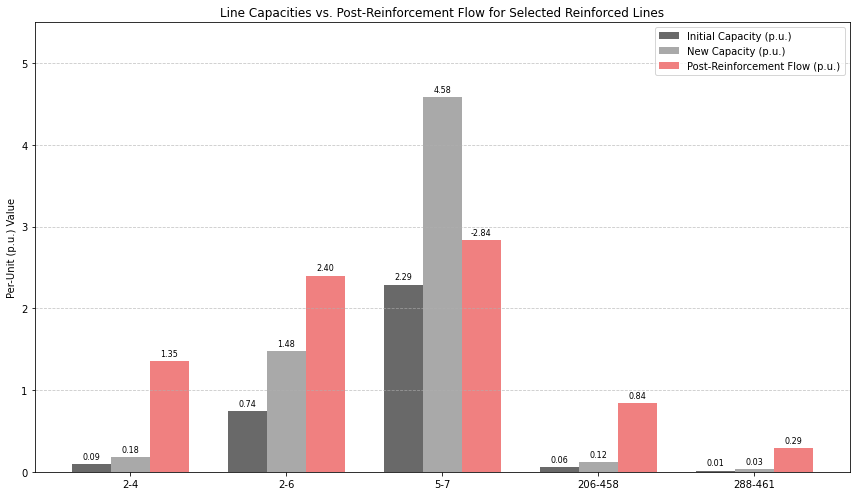

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Data from your Table ---
# This data should ideally be read from your 'pyomo_milp_results.csv' or similar
# For this example, I'm hardcoding it based on your provided image.
# Make sure to select the *reinforced* lines for this chart.
data = {
    'Line (u-v)': ['2-4', '2-6', '5-7', '206-458', '288-461'],
    'Initial Capacity (p.u.)': [0.0897, 0.7395, 2.2911, 0.0586, 0.0142],
    # 'Reinforced (y=1)': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes'], # Not directly plotted but implies New Capacity
    'New Capacity (p.u.)': [0.1795, 1.4791, 4.5822, 0.1172, 0.0284], # This is Initial * ReinforcementFactor
    # 'Reinforcement Cost': [902.00, 74645.00, 33471.00, 856.00, 1433.00], # Not plotted here
    'Post-Reinf. Flow (p.u.)': [1.352, 2.400, -2.836, 0.843, 0.293],
    # 'Remaining Overload (p.u.)': [1.173, 0.921, 0.000, 0.725, 0.264] # Can be inferred from Flow vs New Capacity
}
df_chart = pd.DataFrame(data)

# Calculate absolute post-reinforcement flow for plotting against capacity
df_chart['Abs Post-Reinf. Flow (p.u.)'] = df_chart['Post-Reinf. Flow (p.u.)'].abs()

# --- Plotting ---
labels = df_chart['Line (u-v)']
initial_caps = df_chart['Initial Capacity (p.u.)']
new_caps = df_chart['New Capacity (p.u.)']
post_flows_abs = df_chart['Abs Post-Reinf. Flow (p.u.)']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7)) # Adjusted figure size for better readability

rects1 = ax.bar(x - width, initial_caps, width, label='Initial Capacity (p.u.)', color='dimgray')
rects2 = ax.bar(x, new_caps, width, label='New Capacity (p.u.)', color='darkgray') # Reinforced capacity
rects3 = ax.bar(x + width, post_flows_abs, width, label='Post-Reinforcement Flow (p.u.)', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Per-Unit (p.u.) Value')
ax.set_title('Line Capacities vs. Post-Reinforcement Flow for Selected Reinforced Lines')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of bars
def autolabel(rects, values):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{values[i]:.2f}', # Use original values for flow if needed, or abs for display
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1, initial_caps)
autolabel(rects2, new_caps)
# For flow, label with the original flow value (including sign) for more info,
# even though the bar height is absolute. Or label with absolute value if preferred.
autolabel(rects3, df_chart['Post-Reinf. Flow (p.u.)']) # Using original flow for label

# Adjust y-axis limit to ensure all bars and labels are visible
max_y_val = max(initial_caps.max(), new_caps.max(), post_flows_abs.max())
ax.set_ylim(0, max_y_val * 1.2) # Add 20% buffer at the top

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

# To save the figure:
# output_plot_dir = "output_plots" # Create this directory if it doesn't exist
# os.makedirs(output_plot_dir, exist_ok=True)
# plot_filename = os.path.join(output_plot_dir, "optimization_results_comparison_chart.png")
# plt.savefig(plot_filename, dpi=300)
# print(f"Saved chart to {plot_filename}")

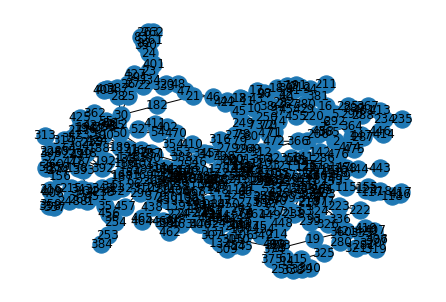

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.read_graphml("active_network_lcc.graphml")
nx.draw(G, with_labels=True)
plt.savefig("active_network_lcc.pdf")  # or .png

In [ ]:
cmd grbgetkey 55f387a8-c136-42cc-9c9b-793e311bf2bc